In [4]:
import tensorflow as tf
from tensorflow import keras as keras
print(tf.__version__)

print(keras.__version__)

2.3.1
2.4.0


In [5]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


(15060, 41)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

from tensorflow.keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dropout(0.4))
model.add(Dense(50,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(10,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_Adam, early_stopping])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4200      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

943/943 [==============================] - 1s 1ms/step - loss: 0.3652 - accuracy: 0.8313 - val_loss: 0.3363 - val_accuracy: 0.8457
Epoch 50/100
943/943 [==============================] - 1s 2ms/step - loss: 0.3681 - accuracy: 0.8305 - val_loss: 0.3363 - val_accuracy: 0.8452
Epoch 51/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3641 - accuracy: 0.8351 - val_loss: 0.3363 - val_accuracy: 0.8452
Epoch 52/100
943/943 [==============================] - 1s 2ms/step - loss: 0.3665 - accuracy: 0.8324 - val_loss: 0.3363 - val_accuracy: 0.8452
Epoch 53/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3634 - accuracy: 0.8340 - val_loss: 0.3362 - val_accuracy: 0.8452
Epoch 54/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3635 - accuracy: 0.8340 - val_loss: 0.3362 - val_accuracy: 0.8453
Epoch 55/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3647 - accuracy: 0.8332 - val_loss: 0.3361 - val_accuracy: 0.8453
Epoch

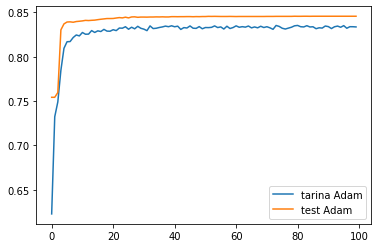

In [5]:
plt.plot(history_Adam.history['accuracy'], label = "tarina Adam")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam")


plt.legend()
plt.show()

# Zad.
Do do modelu 
```python
model.add(Dropout(0.8))
```
po każdej warstwie.

Zwizualizuj wyniki dla obu modeli.

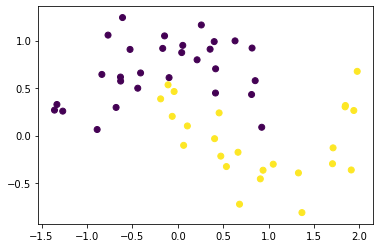

In [4]:
from sklearn.datasets import make_moons
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)
# split into train and test
# n_train = 30
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=2)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

from tensorflow.keras.callbacks import History
history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=4000, callbacks=[history_Adam])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1000)              3000      
_________________________________________________________________
dense_5 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_6 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4000
2/2 [==============================] - 0s 124ms/step - loss: 0.7105 - accuracy: 0.5094 - val_loss: 0.7299 - val_accuracy: 0.4468
Epoch 2/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.6557 - accuracy: 0.5660 - val

Epoch 110/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0520 - accuracy: 0.9811 - val_loss: 0.2195 - val_accuracy: 0.9149
Epoch 111/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0499 - accuracy: 1.0000 - val_loss: 0.2065 - val_accuracy: 0.9149
Epoch 112/4000
2/2 [==============================] - 0s 24ms/step - loss: 0.0467 - accuracy: 1.0000 - val_loss: 0.1907 - val_accuracy: 0.8936
Epoch 113/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0473 - accuracy: 1.0000 - val_loss: 0.1867 - val_accuracy: 0.8936
Epoch 114/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0471 - accuracy: 1.0000 - val_loss: 0.1938 - val_accuracy: 0.8936
Epoch 115/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0428 - accuracy: 1.0000 - val_loss: 0.1942 - val_accuracy: 0.9149
Epoch 116/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0429 - accuracy: 1.0000 - val_loss: 0.1987 - val_accuracy: 0.9149

2/2 [==============================] - 0s 16ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.2089 - val_accuracy: 0.9149
Epoch 225/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.2064 - val_accuracy: 0.9149
Epoch 226/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.2062 - val_accuracy: 0.9149
Epoch 227/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.2074 - val_accuracy: 0.9149
Epoch 228/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.2107 - val_accuracy: 0.9149
Epoch 229/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.2137 - val_accuracy: 0.9149
Epoch 230/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.2151 - val_accuracy: 0.9149
Epoch 231/4000

2/2 [==============================] - 0s 20ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.2292 - val_accuracy: 0.9149
Epoch 282/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.2302 - val_accuracy: 0.9149
Epoch 283/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.2310 - val_accuracy: 0.9149
Epoch 284/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.2331 - val_accuracy: 0.9149
Epoch 285/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.2325 - val_accuracy: 0.9149
Epoch 286/4000
2/2 [==============================] - 0s 25ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.2320 - val_accuracy: 0.9149
Epoch 287/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.2320 - val_accuracy: 0.9149
Epoch 288/4000

Epoch 338/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.2473 - val_accuracy: 0.9149
Epoch 339/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.2470 - val_accuracy: 0.9149
Epoch 340/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.2469 - val_accuracy: 0.9149
Epoch 341/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.2475 - val_accuracy: 0.9149
Epoch 342/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.2470 - val_accuracy: 0.9149
Epoch 343/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2466 - val_accuracy: 0.9149
Epoch 344/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.2466 - val_accuracy: 0.9149

2/2 [==============================] - 0s 18ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2781 - val_accuracy: 0.9149
Epoch 453/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2788 - val_accuracy: 0.9149
Epoch 454/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2788 - val_accuracy: 0.9149
Epoch 455/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2778 - val_accuracy: 0.9149
Epoch 456/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2783 - val_accuracy: 0.9149
Epoch 457/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2799 - val_accuracy: 0.9149
Epoch 458/4000
2/2 [==============================] - 0s 17ms/step - loss: 9.7860e-04 - accuracy: 1.0000 - val_loss: 0.2807 - val_accuracy: 0.9149
Epoch 459/

2/2 [==============================] - 0s 15ms/step - loss: 7.4462e-04 - accuracy: 1.0000 - val_loss: 0.2883 - val_accuracy: 0.9149
Epoch 509/4000
2/2 [==============================] - 0s 19ms/step - loss: 7.4132e-04 - accuracy: 1.0000 - val_loss: 0.2885 - val_accuracy: 0.9149
Epoch 510/4000
2/2 [==============================] - 0s 17ms/step - loss: 7.5597e-04 - accuracy: 1.0000 - val_loss: 0.2893 - val_accuracy: 0.9149
Epoch 511/4000
2/2 [==============================] - 0s 16ms/step - loss: 7.4592e-04 - accuracy: 1.0000 - val_loss: 0.2890 - val_accuracy: 0.9149
Epoch 512/4000
2/2 [==============================] - 0s 18ms/step - loss: 7.2709e-04 - accuracy: 1.0000 - val_loss: 0.2899 - val_accuracy: 0.9149
Epoch 513/4000
2/2 [==============================] - 0s 17ms/step - loss: 7.1809e-04 - accuracy: 1.0000 - val_loss: 0.2917 - val_accuracy: 0.9149
Epoch 514/4000
2/2 [==============================] - 0s 15ms/step - loss: 7.5753e-04 - accuracy: 1.0000 - val_loss: 0.2932 - val_acc

Epoch 564/4000
2/2 [==============================] - 0s 19ms/step - loss: 5.5932e-04 - accuracy: 1.0000 - val_loss: 0.3015 - val_accuracy: 0.9149
Epoch 565/4000
2/2 [==============================] - 0s 24ms/step - loss: 5.7137e-04 - accuracy: 1.0000 - val_loss: 0.3016 - val_accuracy: 0.9149
Epoch 566/4000
2/2 [==============================] - 0s 15ms/step - loss: 5.5366e-04 - accuracy: 1.0000 - val_loss: 0.3029 - val_accuracy: 0.9149
Epoch 567/4000
2/2 [==============================] - 0s 16ms/step - loss: 5.7338e-04 - accuracy: 1.0000 - val_loss: 0.3042 - val_accuracy: 0.9149
Epoch 568/4000
2/2 [==============================] - 0s 17ms/step - loss: 5.6135e-04 - accuracy: 1.0000 - val_loss: 0.3044 - val_accuracy: 0.9149
Epoch 569/4000
2/2 [==============================] - 0s 18ms/step - loss: 5.4622e-04 - accuracy: 1.0000 - val_loss: 0.3040 - val_accuracy: 0.9149
Epoch 570/4000
2/2 [==============================] - 0s 24ms/step - loss: 5.3861e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 620/4000
2/2 [==============================] - 0s 17ms/step - loss: 4.4038e-04 - accuracy: 1.0000 - val_loss: 0.3154 - val_accuracy: 0.9149
Epoch 621/4000
2/2 [==============================] - 0s 18ms/step - loss: 4.3907e-04 - accuracy: 1.0000 - val_loss: 0.3147 - val_accuracy: 0.9149
Epoch 622/4000
2/2 [==============================] - 0s 16ms/step - loss: 4.5154e-04 - accuracy: 1.0000 - val_loss: 0.3131 - val_accuracy: 0.9149
Epoch 623/4000
2/2 [==============================] - 0s 17ms/step - loss: 4.3266e-04 - accuracy: 1.0000 - val_loss: 0.3131 - val_accuracy: 0.9149
Epoch 624/4000
2/2 [==============================] - 0s 17ms/step - loss: 4.3104e-04 - accuracy: 1.0000 - val_loss: 0.3126 - val_accuracy: 0.9149
Epoch 625/4000
2/2 [==============================] - 0s 15ms/step - loss: 4.3113e-04 - accuracy: 1.0000 - val_loss: 0.3127 - val_accuracy: 0.9149
Epoch 626/4000
2/2 [==============================] - 0s 18ms/step - loss: 4.2901e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 676/4000
2/2 [==============================] - 0s 16ms/step - loss: 3.5047e-04 - accuracy: 1.0000 - val_loss: 0.3280 - val_accuracy: 0.9149
Epoch 677/4000
2/2 [==============================] - 0s 18ms/step - loss: 3.5629e-04 - accuracy: 1.0000 - val_loss: 0.3288 - val_accuracy: 0.9149
Epoch 678/4000
2/2 [==============================] - 0s 23ms/step - loss: 3.6392e-04 - accuracy: 1.0000 - val_loss: 0.3294 - val_accuracy: 0.9149
Epoch 679/4000
2/2 [==============================] - 0s 18ms/step - loss: 3.6120e-04 - accuracy: 1.0000 - val_loss: 0.3286 - val_accuracy: 0.9149
Epoch 680/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.6149e-04 - accuracy: 1.0000 - val_loss: 0.3272 - val_accuracy: 0.9149
Epoch 681/4000
2/2 [==============================] - 0s 18ms/step - loss: 3.4144e-04 - accuracy: 1.0000 - val_loss: 0.3264 - val_accuracy: 0.9149
Epoch 682/4000
2/2 [==============================] - 0s 18ms/step - loss: 3.3820e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 731/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.8982e-04 - accuracy: 1.0000 - val_loss: 0.3307 - val_accuracy: 0.9149
Epoch 732/4000
2/2 [==============================] - 0s 16ms/step - loss: 2.8134e-04 - accuracy: 1.0000 - val_loss: 0.3305 - val_accuracy: 0.9149
Epoch 733/4000
2/2 [==============================] - 0s 20ms/step - loss: 2.8536e-04 - accuracy: 1.0000 - val_loss: 0.3304 - val_accuracy: 0.9149
Epoch 734/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.7930e-04 - accuracy: 1.0000 - val_loss: 0.3311 - val_accuracy: 0.9149
Epoch 735/4000
2/2 [==============================] - 0s 16ms/step - loss: 2.7891e-04 - accuracy: 1.0000 - val_loss: 0.3316 - val_accuracy: 0.9149
Epoch 736/4000
2/2 [==============================] - 0s 15ms/step - loss: 2.8443e-04 - accuracy: 1.0000 - val_loss: 0.3321 - val_accuracy: 0.9149
Epoch 737/4000
2/2 [==============================] - 0s 16ms/step - loss: 2.8408e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 787/4000
2/2 [==============================] - 0s 16ms/step - loss: 2.3435e-04 - accuracy: 1.0000 - val_loss: 0.3388 - val_accuracy: 0.9149
Epoch 788/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.3551e-04 - accuracy: 1.0000 - val_loss: 0.3390 - val_accuracy: 0.9149
Epoch 789/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.3384e-04 - accuracy: 1.0000 - val_loss: 0.3398 - val_accuracy: 0.9149
Epoch 790/4000
2/2 [==============================] - 0s 16ms/step - loss: 2.3452e-04 - accuracy: 1.0000 - val_loss: 0.3402 - val_accuracy: 0.9149
Epoch 791/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.3757e-04 - accuracy: 1.0000 - val_loss: 0.3401 - val_accuracy: 0.9149
Epoch 792/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.3264e-04 - accuracy: 1.0000 - val_loss: 0.3390 - val_accuracy: 0.9149
Epoch 793/4000
2/2 [==============================] - 0s 15ms/step - loss: 2.2988e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 843/4000
2/2 [==============================] - 0s 18ms/step - loss: 1.9730e-04 - accuracy: 1.0000 - val_loss: 0.3480 - val_accuracy: 0.9149
Epoch 844/4000
2/2 [==============================] - 0s 22ms/step - loss: 2.0325e-04 - accuracy: 1.0000 - val_loss: 0.3489 - val_accuracy: 0.9149
Epoch 845/4000
2/2 [==============================] - 0s 15ms/step - loss: 1.9771e-04 - accuracy: 1.0000 - val_loss: 0.3486 - val_accuracy: 0.9149
Epoch 846/4000
2/2 [==============================] - 0s 15ms/step - loss: 1.9651e-04 - accuracy: 1.0000 - val_loss: 0.3477 - val_accuracy: 0.9149
Epoch 847/4000
2/2 [==============================] - 0s 18ms/step - loss: 1.9976e-04 - accuracy: 1.0000 - val_loss: 0.3468 - val_accuracy: 0.9149
Epoch 848/4000
2/2 [==============================] - 0s 19ms/step - loss: 1.9763e-04 - accuracy: 1.0000 - val_loss: 0.3469 - val_accuracy: 0.9149
Epoch 849/4000
2/2 [==============================] - 0s 19ms/step - loss: 1.9356e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 899/4000
2/2 [==============================] - 0s 18ms/step - loss: 1.6771e-04 - accuracy: 1.0000 - val_loss: 0.3540 - val_accuracy: 0.9149
Epoch 900/4000
2/2 [==============================] - 0s 18ms/step - loss: 1.6764e-04 - accuracy: 1.0000 - val_loss: 0.3534 - val_accuracy: 0.9149
Epoch 901/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.6630e-04 - accuracy: 1.0000 - val_loss: 0.3525 - val_accuracy: 0.9149
Epoch 902/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.7183e-04 - accuracy: 1.0000 - val_loss: 0.3512 - val_accuracy: 0.9149
Epoch 903/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.6758e-04 - accuracy: 1.0000 - val_loss: 0.3514 - val_accuracy: 0.9149
Epoch 904/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.6684e-04 - accuracy: 1.0000 - val_loss: 0.3520 - val_accuracy: 0.9149
Epoch 905/4000
2/2 [==============================] - 0s 13ms/step - loss: 1.6708e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 955/4000
2/2 [==============================] - 0s 18ms/step - loss: 1.4300e-04 - accuracy: 1.0000 - val_loss: 0.3597 - val_accuracy: 0.9149
Epoch 956/4000
2/2 [==============================] - 0s 15ms/step - loss: 1.4256e-04 - accuracy: 1.0000 - val_loss: 0.3599 - val_accuracy: 0.9149
Epoch 957/4000
2/2 [==============================] - 0s 14ms/step - loss: 1.4418e-04 - accuracy: 1.0000 - val_loss: 0.3604 - val_accuracy: 0.9149
Epoch 958/4000
2/2 [==============================] - 0s 15ms/step - loss: 1.4421e-04 - accuracy: 1.0000 - val_loss: 0.3599 - val_accuracy: 0.9149
Epoch 959/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.4151e-04 - accuracy: 1.0000 - val_loss: 0.3605 - val_accuracy: 0.9149
Epoch 960/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.4095e-04 - accuracy: 1.0000 - val_loss: 0.3610 - val_accuracy: 0.9149
Epoch 961/4000
2/2 [==============================] - 0s 13ms/step - loss: 1.4052e-04 - accuracy: 1.0000 - val_loss: 0

2/2 [==============================] - 0s 20ms/step - loss: 1.0887e-04 - accuracy: 1.0000 - val_loss: 0.3762 - val_accuracy: 0.9149
Epoch 1066/4000
2/2 [==============================] - 0s 21ms/step - loss: 1.0855e-04 - accuracy: 1.0000 - val_loss: 0.3758 - val_accuracy: 0.9149
Epoch 1067/4000
2/2 [==============================] - 0s 22ms/step - loss: 1.0782e-04 - accuracy: 1.0000 - val_loss: 0.3754 - val_accuracy: 0.9149
Epoch 1068/4000
2/2 [==============================] - 0s 19ms/step - loss: 1.0772e-04 - accuracy: 1.0000 - val_loss: 0.3749 - val_accuracy: 0.9149
Epoch 1069/4000
2/2 [==============================] - 0s 23ms/step - loss: 1.0958e-04 - accuracy: 1.0000 - val_loss: 0.3737 - val_accuracy: 0.9149
Epoch 1070/4000
2/2 [==============================] - 0s 15ms/step - loss: 1.0639e-04 - accuracy: 1.0000 - val_loss: 0.3734 - val_accuracy: 0.9149
Epoch 1071/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.0702e-04 - accuracy: 1.0000 - val_loss: 0.3734 - v

2/2 [==============================] - 0s 20ms/step - loss: 8.4335e-05 - accuracy: 1.0000 - val_loss: 0.3847 - val_accuracy: 0.9149
Epoch 1176/4000
2/2 [==============================] - 0s 18ms/step - loss: 8.3062e-05 - accuracy: 1.0000 - val_loss: 0.3850 - val_accuracy: 0.9149
Epoch 1177/4000
2/2 [==============================] - 0s 20ms/step - loss: 8.3420e-05 - accuracy: 1.0000 - val_loss: 0.3852 - val_accuracy: 0.9149
Epoch 1178/4000
2/2 [==============================] - 0s 20ms/step - loss: 8.2733e-05 - accuracy: 1.0000 - val_loss: 0.3858 - val_accuracy: 0.9149
Epoch 1179/4000
2/2 [==============================] - 0s 22ms/step - loss: 8.2701e-05 - accuracy: 1.0000 - val_loss: 0.3863 - val_accuracy: 0.9149
Epoch 1180/4000
2/2 [==============================] - 0s 22ms/step - loss: 8.2617e-05 - accuracy: 1.0000 - val_loss: 0.3865 - val_accuracy: 0.9149
Epoch 1181/4000
2/2 [==============================] - 0s 17ms/step - loss: 8.3261e-05 - accuracy: 1.0000 - val_loss: 0.3866 - v

2/2 [==============================] - 0s 19ms/step - loss: 6.5863e-05 - accuracy: 1.0000 - val_loss: 0.3932 - val_accuracy: 0.9149
Epoch 1286/4000
2/2 [==============================] - 0s 18ms/step - loss: 6.5782e-05 - accuracy: 1.0000 - val_loss: 0.3934 - val_accuracy: 0.9149
Epoch 1287/4000
2/2 [==============================] - 0s 17ms/step - loss: 6.5621e-05 - accuracy: 1.0000 - val_loss: 0.3937 - val_accuracy: 0.9149
Epoch 1288/4000
2/2 [==============================] - 0s 19ms/step - loss: 6.5446e-05 - accuracy: 1.0000 - val_loss: 0.3939 - val_accuracy: 0.9149
Epoch 1289/4000
2/2 [==============================] - 0s 19ms/step - loss: 6.6065e-05 - accuracy: 1.0000 - val_loss: 0.3945 - val_accuracy: 0.9149
Epoch 1290/4000
2/2 [==============================] - 0s 21ms/step - loss: 6.5490e-05 - accuracy: 1.0000 - val_loss: 0.3946 - val_accuracy: 0.9149
Epoch 1291/4000
2/2 [==============================] - 0s 19ms/step - loss: 6.4931e-05 - accuracy: 1.0000 - val_loss: 0.3942 - v

2/2 [==============================] - 0s 20ms/step - loss: 5.2912e-05 - accuracy: 1.0000 - val_loss: 0.4054 - val_accuracy: 0.9149
Epoch 1396/4000
2/2 [==============================] - 0s 17ms/step - loss: 5.3368e-05 - accuracy: 1.0000 - val_loss: 0.4051 - val_accuracy: 0.9149
Epoch 1397/4000
2/2 [==============================] - 0s 19ms/step - loss: 5.2705e-05 - accuracy: 1.0000 - val_loss: 0.4053 - val_accuracy: 0.9149
Epoch 1398/4000
2/2 [==============================] - 0s 16ms/step - loss: 5.2950e-05 - accuracy: 1.0000 - val_loss: 0.4054 - val_accuracy: 0.9149
Epoch 1399/4000
2/2 [==============================] - 0s 20ms/step - loss: 5.2519e-05 - accuracy: 1.0000 - val_loss: 0.4059 - val_accuracy: 0.9149
Epoch 1400/4000
2/2 [==============================] - 0s 20ms/step - loss: 5.2682e-05 - accuracy: 1.0000 - val_loss: 0.4062 - val_accuracy: 0.9149
Epoch 1401/4000
2/2 [==============================] - 0s 20ms/step - loss: 5.2407e-05 - accuracy: 1.0000 - val_loss: 0.4068 - v

2/2 [==============================] - 0s 21ms/step - loss: 4.3217e-05 - accuracy: 1.0000 - val_loss: 0.4147 - val_accuracy: 0.9149
Epoch 1506/4000
2/2 [==============================] - 0s 19ms/step - loss: 4.3105e-05 - accuracy: 1.0000 - val_loss: 0.4149 - val_accuracy: 0.9149
Epoch 1507/4000
2/2 [==============================] - 0s 18ms/step - loss: 4.3055e-05 - accuracy: 1.0000 - val_loss: 0.4150 - val_accuracy: 0.9149
Epoch 1508/4000
2/2 [==============================] - 0s 22ms/step - loss: 4.3236e-05 - accuracy: 1.0000 - val_loss: 0.4150 - val_accuracy: 0.9149
Epoch 1509/4000
2/2 [==============================] - 0s 20ms/step - loss: 4.2896e-05 - accuracy: 1.0000 - val_loss: 0.4156 - val_accuracy: 0.9149
Epoch 1510/4000
2/2 [==============================] - 0s 22ms/step - loss: 4.3357e-05 - accuracy: 1.0000 - val_loss: 0.4162 - val_accuracy: 0.9149
Epoch 1511/4000
2/2 [==============================] - 0s 20ms/step - loss: 4.3221e-05 - accuracy: 1.0000 - val_loss: 0.4159 - v

2/2 [==============================] - 0s 21ms/step - loss: 3.5844e-05 - accuracy: 1.0000 - val_loss: 0.4235 - val_accuracy: 0.9149
Epoch 1616/4000
2/2 [==============================] - 0s 24ms/step - loss: 3.5712e-05 - accuracy: 1.0000 - val_loss: 0.4230 - val_accuracy: 0.9149
Epoch 1617/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.6144e-05 - accuracy: 1.0000 - val_loss: 0.4226 - val_accuracy: 0.9149
Epoch 1618/4000
2/2 [==============================] - 0s 15ms/step - loss: 3.5613e-05 - accuracy: 1.0000 - val_loss: 0.4228 - val_accuracy: 0.9149
Epoch 1619/4000
2/2 [==============================] - 0s 23ms/step - loss: 3.5747e-05 - accuracy: 1.0000 - val_loss: 0.4228 - val_accuracy: 0.9149
Epoch 1620/4000
2/2 [==============================] - 0s 15ms/step - loss: 3.5486e-05 - accuracy: 1.0000 - val_loss: 0.4235 - val_accuracy: 0.9149
Epoch 1621/4000
2/2 [==============================] - 0s 18ms/step - loss: 3.5420e-05 - accuracy: 1.0000 - val_loss: 0.4241 - v

2/2 [==============================] - 0s 17ms/step - loss: 2.9843e-05 - accuracy: 1.0000 - val_loss: 0.4311 - val_accuracy: 0.9149
Epoch 1726/4000
2/2 [==============================] - 0s 15ms/step - loss: 2.9722e-05 - accuracy: 1.0000 - val_loss: 0.4304 - val_accuracy: 0.9149
Epoch 1727/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.9690e-05 - accuracy: 1.0000 - val_loss: 0.4295 - val_accuracy: 0.9149
Epoch 1728/4000
2/2 [==============================] - 0s 14ms/step - loss: 2.9982e-05 - accuracy: 1.0000 - val_loss: 0.4287 - val_accuracy: 0.9149
Epoch 1729/4000
2/2 [==============================] - 0s 27ms/step - loss: 3.0439e-05 - accuracy: 1.0000 - val_loss: 0.4284 - val_accuracy: 0.9149
Epoch 1730/4000
2/2 [==============================] - 0s 15ms/step - loss: 3.0068e-05 - accuracy: 1.0000 - val_loss: 0.4289 - val_accuracy: 0.9149
Epoch 1731/4000
2/2 [==============================] - 0s 23ms/step - loss: 3.0194e-05 - accuracy: 1.0000 - val_loss: 0.4297 - v

2/2 [==============================] - 0s 14ms/step - loss: 2.5072e-05 - accuracy: 1.0000 - val_loss: 0.4405 - val_accuracy: 0.9149
Epoch 1836/4000
2/2 [==============================] - 0s 15ms/step - loss: 2.5049e-05 - accuracy: 1.0000 - val_loss: 0.4408 - val_accuracy: 0.9149
Epoch 1837/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.5146e-05 - accuracy: 1.0000 - val_loss: 0.4409 - val_accuracy: 0.9149
Epoch 1838/4000
2/2 [==============================] - 0s 15ms/step - loss: 2.5045e-05 - accuracy: 1.0000 - val_loss: 0.4412 - val_accuracy: 0.9149
Epoch 1839/4000
2/2 [==============================] - 0s 15ms/step - loss: 2.4957e-05 - accuracy: 1.0000 - val_loss: 0.4418 - val_accuracy: 0.9149
Epoch 1840/4000
2/2 [==============================] - 0s 14ms/step - loss: 2.5058e-05 - accuracy: 1.0000 - val_loss: 0.4420 - val_accuracy: 0.9149
Epoch 1841/4000
2/2 [==============================] - 0s 15ms/step - loss: 2.4945e-05 - accuracy: 1.0000 - val_loss: 0.4424 - v

2/2 [==============================] - 0s 20ms/step - loss: 2.1389e-05 - accuracy: 1.0000 - val_loss: 0.4450 - val_accuracy: 0.9149
Epoch 1946/4000
2/2 [==============================] - 0s 14ms/step - loss: 2.1300e-05 - accuracy: 1.0000 - val_loss: 0.4446 - val_accuracy: 0.9149
Epoch 1947/4000
2/2 [==============================] - 0s 15ms/step - loss: 2.1370e-05 - accuracy: 1.0000 - val_loss: 0.4446 - val_accuracy: 0.9149
Epoch 1948/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.1275e-05 - accuracy: 1.0000 - val_loss: 0.4444 - val_accuracy: 0.9149
Epoch 1949/4000
2/2 [==============================] - 0s 15ms/step - loss: 2.1276e-05 - accuracy: 1.0000 - val_loss: 0.4444 - val_accuracy: 0.9149
Epoch 1950/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.1375e-05 - accuracy: 1.0000 - val_loss: 0.4445 - val_accuracy: 0.9149
Epoch 1951/4000
2/2 [==============================] - 0s 15ms/step - loss: 2.1452e-05 - accuracy: 1.0000 - val_loss: 0.4453 - v

2/2 [==============================] - 0s 22ms/step - loss: 1.8368e-05 - accuracy: 1.0000 - val_loss: 0.4559 - val_accuracy: 0.9149
Epoch 2056/4000
2/2 [==============================] - 0s 19ms/step - loss: 1.8257e-05 - accuracy: 1.0000 - val_loss: 0.4550 - val_accuracy: 0.9149
Epoch 2057/4000
2/2 [==============================] - 0s 18ms/step - loss: 1.8152e-05 - accuracy: 1.0000 - val_loss: 0.4542 - val_accuracy: 0.9149
Epoch 2058/4000
2/2 [==============================] - 0s 15ms/step - loss: 1.8079e-05 - accuracy: 1.0000 - val_loss: 0.4535 - val_accuracy: 0.9149
Epoch 2059/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.8040e-05 - accuracy: 1.0000 - val_loss: 0.4530 - val_accuracy: 0.9149
Epoch 2060/4000
2/2 [==============================] - 0s 18ms/step - loss: 1.7996e-05 - accuracy: 1.0000 - val_loss: 0.4525 - val_accuracy: 0.9149
Epoch 2061/4000
2/2 [==============================] - 0s 19ms/step - loss: 1.8084e-05 - accuracy: 1.0000 - val_loss: 0.4518 - v

2/2 [==============================] - 0s 17ms/step - loss: 1.5573e-05 - accuracy: 1.0000 - val_loss: 0.4612 - val_accuracy: 0.9149
Epoch 2166/4000
2/2 [==============================] - 0s 14ms/step - loss: 1.5563e-05 - accuracy: 1.0000 - val_loss: 0.4613 - val_accuracy: 0.9149
Epoch 2167/4000
2/2 [==============================] - 0s 14ms/step - loss: 1.5623e-05 - accuracy: 1.0000 - val_loss: 0.4611 - val_accuracy: 0.9149
Epoch 2168/4000
2/2 [==============================] - 0s 15ms/step - loss: 1.5670e-05 - accuracy: 1.0000 - val_loss: 0.4615 - val_accuracy: 0.9149
Epoch 2169/4000
2/2 [==============================] - 0s 15ms/step - loss: 1.5519e-05 - accuracy: 1.0000 - val_loss: 0.4612 - val_accuracy: 0.9149
Epoch 2170/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.5463e-05 - accuracy: 1.0000 - val_loss: 0.4610 - val_accuracy: 0.9149
Epoch 2171/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.5439e-05 - accuracy: 1.0000 - val_loss: 0.4607 - v

2/2 [==============================] - 0s 20ms/step - loss: 1.3458e-05 - accuracy: 1.0000 - val_loss: 0.4696 - val_accuracy: 0.9149
Epoch 2276/4000
2/2 [==============================] - 0s 21ms/step - loss: 1.3491e-05 - accuracy: 1.0000 - val_loss: 0.4698 - val_accuracy: 0.9149
Epoch 2277/4000
2/2 [==============================] - 0s 19ms/step - loss: 1.3496e-05 - accuracy: 1.0000 - val_loss: 0.4702 - val_accuracy: 0.9149
Epoch 2278/4000
2/2 [==============================] - 0s 14ms/step - loss: 1.3490e-05 - accuracy: 1.0000 - val_loss: 0.4702 - val_accuracy: 0.9149
Epoch 2279/4000
2/2 [==============================] - 0s 15ms/step - loss: 1.3459e-05 - accuracy: 1.0000 - val_loss: 0.4700 - val_accuracy: 0.9149
Epoch 2280/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.3449e-05 - accuracy: 1.0000 - val_loss: 0.4697 - val_accuracy: 0.9149
Epoch 2281/4000
2/2 [==============================] - 0s 19ms/step - loss: 1.3536e-05 - accuracy: 1.0000 - val_loss: 0.4689 - v

2/2 [==============================] - 0s 17ms/step - loss: 1.1569e-05 - accuracy: 1.0000 - val_loss: 0.4729 - val_accuracy: 0.9149
Epoch 2386/4000
2/2 [==============================] - 0s 22ms/step - loss: 1.1643e-05 - accuracy: 1.0000 - val_loss: 0.4727 - val_accuracy: 0.9149
Epoch 2387/4000
2/2 [==============================] - 0s 15ms/step - loss: 1.1570e-05 - accuracy: 1.0000 - val_loss: 0.4730 - val_accuracy: 0.9149
Epoch 2388/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.1525e-05 - accuracy: 1.0000 - val_loss: 0.4737 - val_accuracy: 0.9149
Epoch 2389/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.1488e-05 - accuracy: 1.0000 - val_loss: 0.4744 - val_accuracy: 0.9149
Epoch 2390/4000
2/2 [==============================] - 0s 15ms/step - loss: 1.1604e-05 - accuracy: 1.0000 - val_loss: 0.4750 - val_accuracy: 0.9149
Epoch 2391/4000
2/2 [==============================] - 0s 19ms/step - loss: 1.1465e-05 - accuracy: 1.0000 - val_loss: 0.4751 - v

2/2 [==============================] - 0s 18ms/step - loss: 1.0071e-05 - accuracy: 1.0000 - val_loss: 0.4784 - val_accuracy: 0.9149
Epoch 2496/4000
2/2 [==============================] - 0s 15ms/step - loss: 1.0024e-05 - accuracy: 1.0000 - val_loss: 0.4791 - val_accuracy: 0.9149
Epoch 2497/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.0103e-05 - accuracy: 1.0000 - val_loss: 0.4798 - val_accuracy: 0.9149
Epoch 2498/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.0042e-05 - accuracy: 1.0000 - val_loss: 0.4801 - val_accuracy: 0.9149
Epoch 2499/4000
2/2 [==============================] - 0s 15ms/step - loss: 9.9550e-06 - accuracy: 1.0000 - val_loss: 0.4799 - val_accuracy: 0.9149
Epoch 2500/4000
2/2 [==============================] - 0s 15ms/step - loss: 9.9476e-06 - accuracy: 1.0000 - val_loss: 0.4797 - val_accuracy: 0.9149
Epoch 2501/4000
2/2 [==============================] - 0s 14ms/step - loss: 1.0002e-05 - accuracy: 1.0000 - val_loss: 0.4796 - v

2/2 [==============================] - 0s 15ms/step - loss: 8.7049e-06 - accuracy: 1.0000 - val_loss: 0.4867 - val_accuracy: 0.9149
Epoch 2606/4000
2/2 [==============================] - 0s 16ms/step - loss: 8.7729e-06 - accuracy: 1.0000 - val_loss: 0.4863 - val_accuracy: 0.9149
Epoch 2607/4000
2/2 [==============================] - 0s 14ms/step - loss: 8.7312e-06 - accuracy: 1.0000 - val_loss: 0.4863 - val_accuracy: 0.9149
Epoch 2608/4000
2/2 [==============================] - 0s 15ms/step - loss: 8.6735e-06 - accuracy: 1.0000 - val_loss: 0.4866 - val_accuracy: 0.9149
Epoch 2609/4000
2/2 [==============================] - 0s 14ms/step - loss: 8.6788e-06 - accuracy: 1.0000 - val_loss: 0.4869 - val_accuracy: 0.9149
Epoch 2610/4000
2/2 [==============================] - 0s 15ms/step - loss: 8.6410e-06 - accuracy: 1.0000 - val_loss: 0.4873 - val_accuracy: 0.9149
Epoch 2611/4000
2/2 [==============================] - 0s 17ms/step - loss: 8.6417e-06 - accuracy: 1.0000 - val_loss: 0.4880 - v

2/2 [==============================] - 0s 17ms/step - loss: 7.6131e-06 - accuracy: 1.0000 - val_loss: 0.4935 - val_accuracy: 0.9149
Epoch 2716/4000
2/2 [==============================] - 0s 18ms/step - loss: 7.6327e-06 - accuracy: 1.0000 - val_loss: 0.4935 - val_accuracy: 0.9149
Epoch 2717/4000
2/2 [==============================] - 0s 18ms/step - loss: 7.5920e-06 - accuracy: 1.0000 - val_loss: 0.4931 - val_accuracy: 0.9149
Epoch 2718/4000
2/2 [==============================] - 0s 16ms/step - loss: 7.5731e-06 - accuracy: 1.0000 - val_loss: 0.4927 - val_accuracy: 0.9149
Epoch 2719/4000
2/2 [==============================] - 0s 17ms/step - loss: 7.5678e-06 - accuracy: 1.0000 - val_loss: 0.4925 - val_accuracy: 0.9149
Epoch 2720/4000
2/2 [==============================] - 0s 15ms/step - loss: 7.5468e-06 - accuracy: 1.0000 - val_loss: 0.4921 - val_accuracy: 0.9149
Epoch 2721/4000
2/2 [==============================] - 0s 15ms/step - loss: 7.5536e-06 - accuracy: 1.0000 - val_loss: 0.4916 - v

2/2 [==============================] - 0s 15ms/step - loss: 6.7023e-06 - accuracy: 1.0000 - val_loss: 0.4972 - val_accuracy: 0.9149
Epoch 2826/4000
2/2 [==============================] - 0s 15ms/step - loss: 6.6803e-06 - accuracy: 1.0000 - val_loss: 0.4971 - val_accuracy: 0.9149
Epoch 2827/4000
2/2 [==============================] - 0s 15ms/step - loss: 6.6596e-06 - accuracy: 1.0000 - val_loss: 0.4968 - val_accuracy: 0.9149
Epoch 2828/4000
2/2 [==============================] - 0s 18ms/step - loss: 6.7015e-06 - accuracy: 1.0000 - val_loss: 0.4968 - val_accuracy: 0.9149
Epoch 2829/4000
2/2 [==============================] - 0s 18ms/step - loss: 6.6999e-06 - accuracy: 1.0000 - val_loss: 0.4972 - val_accuracy: 0.9149
Epoch 2830/4000
2/2 [==============================] - 0s 17ms/step - loss: 6.6715e-06 - accuracy: 1.0000 - val_loss: 0.4974 - val_accuracy: 0.9149
Epoch 2831/4000
2/2 [==============================] - 0s 17ms/step - loss: 6.6198e-06 - accuracy: 1.0000 - val_loss: 0.4974 - v

2/2 [==============================] - 0s 15ms/step - loss: 5.8440e-06 - accuracy: 1.0000 - val_loss: 0.5028 - val_accuracy: 0.9149
Epoch 2936/4000
2/2 [==============================] - 0s 16ms/step - loss: 5.8645e-06 - accuracy: 1.0000 - val_loss: 0.5029 - val_accuracy: 0.9149
Epoch 2937/4000
2/2 [==============================] - 0s 16ms/step - loss: 5.8307e-06 - accuracy: 1.0000 - val_loss: 0.5028 - val_accuracy: 0.9149
Epoch 2938/4000
2/2 [==============================] - 0s 15ms/step - loss: 5.8620e-06 - accuracy: 1.0000 - val_loss: 0.5026 - val_accuracy: 0.9149
Epoch 2939/4000
2/2 [==============================] - 0s 14ms/step - loss: 5.8228e-06 - accuracy: 1.0000 - val_loss: 0.5030 - val_accuracy: 0.9149
Epoch 2940/4000
2/2 [==============================] - 0s 14ms/step - loss: 5.8502e-06 - accuracy: 1.0000 - val_loss: 0.5034 - val_accuracy: 0.9149
Epoch 2941/4000
2/2 [==============================] - 0s 15ms/step - loss: 5.8277e-06 - accuracy: 1.0000 - val_loss: 0.5034 - v

2/2 [==============================] - 0s 13ms/step - loss: 5.1364e-06 - accuracy: 1.0000 - val_loss: 0.5085 - val_accuracy: 0.9149
Epoch 3046/4000
2/2 [==============================] - 0s 13ms/step - loss: 5.1298e-06 - accuracy: 1.0000 - val_loss: 0.5086 - val_accuracy: 0.9149
Epoch 3047/4000
2/2 [==============================] - 0s 15ms/step - loss: 5.1256e-06 - accuracy: 1.0000 - val_loss: 0.5087 - val_accuracy: 0.9149
Epoch 3048/4000
2/2 [==============================] - 0s 13ms/step - loss: 5.1465e-06 - accuracy: 1.0000 - val_loss: 0.5089 - val_accuracy: 0.9149
Epoch 3049/4000
2/2 [==============================] - 0s 15ms/step - loss: 5.1252e-06 - accuracy: 1.0000 - val_loss: 0.5088 - val_accuracy: 0.9149
Epoch 3050/4000
2/2 [==============================] - 0s 14ms/step - loss: 5.1044e-06 - accuracy: 1.0000 - val_loss: 0.5085 - val_accuracy: 0.9149
Epoch 3051/4000
2/2 [==============================] - 0s 13ms/step - loss: 5.1022e-06 - accuracy: 1.0000 - val_loss: 0.5083 - v

2/2 [==============================] - 0s 14ms/step - loss: 4.5532e-06 - accuracy: 1.0000 - val_loss: 0.5160 - val_accuracy: 0.9149
Epoch 3156/4000
2/2 [==============================] - 0s 13ms/step - loss: 4.5309e-06 - accuracy: 1.0000 - val_loss: 0.5160 - val_accuracy: 0.9149
Epoch 3157/4000
2/2 [==============================] - 0s 14ms/step - loss: 4.5119e-06 - accuracy: 1.0000 - val_loss: 0.5156 - val_accuracy: 0.9149
Epoch 3158/4000
2/2 [==============================] - 0s 16ms/step - loss: 4.5455e-06 - accuracy: 1.0000 - val_loss: 0.5151 - val_accuracy: 0.9149
Epoch 3159/4000
2/2 [==============================] - 0s 18ms/step - loss: 4.5212e-06 - accuracy: 1.0000 - val_loss: 0.5150 - val_accuracy: 0.9149
Epoch 3160/4000
2/2 [==============================] - 0s 17ms/step - loss: 4.5231e-06 - accuracy: 1.0000 - val_loss: 0.5153 - val_accuracy: 0.9149
Epoch 3161/4000
2/2 [==============================] - 0s 18ms/step - loss: 4.4844e-06 - accuracy: 1.0000 - val_loss: 0.5153 - v

2/2 [==============================] - 0s 23ms/step - loss: 3.9852e-06 - accuracy: 1.0000 - val_loss: 0.5196 - val_accuracy: 0.9149
Epoch 3266/4000
2/2 [==============================] - 0s 18ms/step - loss: 4.0118e-06 - accuracy: 1.0000 - val_loss: 0.5194 - val_accuracy: 0.9149
Epoch 3267/4000
2/2 [==============================] - 0s 19ms/step - loss: 3.9741e-06 - accuracy: 1.0000 - val_loss: 0.5194 - val_accuracy: 0.9149
Epoch 3268/4000
2/2 [==============================] - 0s 16ms/step - loss: 3.9861e-06 - accuracy: 1.0000 - val_loss: 0.5194 - val_accuracy: 0.9149
Epoch 3269/4000
2/2 [==============================] - 0s 16ms/step - loss: 3.9650e-06 - accuracy: 1.0000 - val_loss: 0.5198 - val_accuracy: 0.9149
Epoch 3270/4000
2/2 [==============================] - 0s 16ms/step - loss: 3.9597e-06 - accuracy: 1.0000 - val_loss: 0.5201 - val_accuracy: 0.9149
Epoch 3271/4000
2/2 [==============================] - 0s 16ms/step - loss: 3.9570e-06 - accuracy: 1.0000 - val_loss: 0.5203 - v

2/2 [==============================] - 0s 17ms/step - loss: 3.5517e-06 - accuracy: 1.0000 - val_loss: 0.5260 - val_accuracy: 0.9149
Epoch 3376/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.5425e-06 - accuracy: 1.0000 - val_loss: 0.5257 - val_accuracy: 0.9149
Epoch 3377/4000
2/2 [==============================] - 0s 16ms/step - loss: 3.5381e-06 - accuracy: 1.0000 - val_loss: 0.5254 - val_accuracy: 0.9149
Epoch 3378/4000
2/2 [==============================] - 0s 14ms/step - loss: 3.5232e-06 - accuracy: 1.0000 - val_loss: 0.5248 - val_accuracy: 0.9149
Epoch 3379/4000
2/2 [==============================] - 0s 14ms/step - loss: 3.5184e-06 - accuracy: 1.0000 - val_loss: 0.5242 - val_accuracy: 0.9149
Epoch 3380/4000
2/2 [==============================] - 0s 15ms/step - loss: 3.5148e-06 - accuracy: 1.0000 - val_loss: 0.5238 - val_accuracy: 0.9149
Epoch 3381/4000
2/2 [==============================] - 0s 14ms/step - loss: 3.5371e-06 - accuracy: 1.0000 - val_loss: 0.5235 - v

2/2 [==============================] - 0s 15ms/step - loss: 3.1281e-06 - accuracy: 1.0000 - val_loss: 0.5294 - val_accuracy: 0.9149
Epoch 3486/4000
2/2 [==============================] - 0s 15ms/step - loss: 3.1246e-06 - accuracy: 1.0000 - val_loss: 0.5294 - val_accuracy: 0.9149
Epoch 3487/4000
2/2 [==============================] - 0s 14ms/step - loss: 3.1388e-06 - accuracy: 1.0000 - val_loss: 0.5293 - val_accuracy: 0.9149
Epoch 3488/4000
2/2 [==============================] - 0s 14ms/step - loss: 3.1175e-06 - accuracy: 1.0000 - val_loss: 0.5294 - val_accuracy: 0.9149
Epoch 3489/4000
2/2 [==============================] - 0s 14ms/step - loss: 3.1328e-06 - accuracy: 1.0000 - val_loss: 0.5297 - val_accuracy: 0.9149
Epoch 3490/4000
2/2 [==============================] - 0s 14ms/step - loss: 3.1101e-06 - accuracy: 1.0000 - val_loss: 0.5295 - val_accuracy: 0.9149
Epoch 3491/4000
2/2 [==============================] - 0s 15ms/step - loss: 3.1129e-06 - accuracy: 1.0000 - val_loss: 0.5293 - v

2/2 [==============================] - 0s 14ms/step - loss: 2.7940e-06 - accuracy: 1.0000 - val_loss: 0.5325 - val_accuracy: 0.9149
Epoch 3596/4000
2/2 [==============================] - 0s 16ms/step - loss: 2.7708e-06 - accuracy: 1.0000 - val_loss: 0.5327 - val_accuracy: 0.9149
Epoch 3597/4000
2/2 [==============================] - 0s 13ms/step - loss: 2.7814e-06 - accuracy: 1.0000 - val_loss: 0.5330 - val_accuracy: 0.9149
Epoch 3598/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.7597e-06 - accuracy: 1.0000 - val_loss: 0.5330 - val_accuracy: 0.9149
Epoch 3599/4000
2/2 [==============================] - 0s 16ms/step - loss: 2.7578e-06 - accuracy: 1.0000 - val_loss: 0.5331 - val_accuracy: 0.9149
Epoch 3600/4000
2/2 [==============================] - 0s 15ms/step - loss: 2.7694e-06 - accuracy: 1.0000 - val_loss: 0.5334 - val_accuracy: 0.9149
Epoch 3601/4000
2/2 [==============================] - 0s 13ms/step - loss: 2.7493e-06 - accuracy: 1.0000 - val_loss: 0.5333 - v

2/2 [==============================] - 0s 16ms/step - loss: 2.4834e-06 - accuracy: 1.0000 - val_loss: 0.5385 - val_accuracy: 0.9149
Epoch 3706/4000
2/2 [==============================] - 0s 16ms/step - loss: 2.4562e-06 - accuracy: 1.0000 - val_loss: 0.5388 - val_accuracy: 0.9149
Epoch 3707/4000
2/2 [==============================] - 0s 14ms/step - loss: 2.4502e-06 - accuracy: 1.0000 - val_loss: 0.5392 - val_accuracy: 0.9149
Epoch 3708/4000
2/2 [==============================] - 0s 14ms/step - loss: 2.4697e-06 - accuracy: 1.0000 - val_loss: 0.5395 - val_accuracy: 0.9149
Epoch 3709/4000
2/2 [==============================] - 0s 15ms/step - loss: 2.4573e-06 - accuracy: 1.0000 - val_loss: 0.5395 - val_accuracy: 0.9149
Epoch 3710/4000
2/2 [==============================] - 0s 16ms/step - loss: 2.4455e-06 - accuracy: 1.0000 - val_loss: 0.5391 - val_accuracy: 0.9149
Epoch 3711/4000
2/2 [==============================] - 0s 14ms/step - loss: 2.4401e-06 - accuracy: 1.0000 - val_loss: 0.5388 - v

2/2 [==============================] - 0s 14ms/step - loss: 2.1794e-06 - accuracy: 1.0000 - val_loss: 0.5440 - val_accuracy: 0.9149
Epoch 3816/4000
2/2 [==============================] - 0s 16ms/step - loss: 2.1864e-06 - accuracy: 1.0000 - val_loss: 0.5440 - val_accuracy: 0.9149
Epoch 3817/4000
2/2 [==============================] - 0s 16ms/step - loss: 2.1758e-06 - accuracy: 1.0000 - val_loss: 0.5438 - val_accuracy: 0.9149
Epoch 3818/4000
2/2 [==============================] - 0s 13ms/step - loss: 2.1945e-06 - accuracy: 1.0000 - val_loss: 0.5433 - val_accuracy: 0.9149
Epoch 3819/4000
2/2 [==============================] - 0s 14ms/step - loss: 2.1731e-06 - accuracy: 1.0000 - val_loss: 0.5433 - val_accuracy: 0.9149
Epoch 3820/4000
2/2 [==============================] - 0s 16ms/step - loss: 2.1830e-06 - accuracy: 1.0000 - val_loss: 0.5429 - val_accuracy: 0.9149
Epoch 3821/4000
2/2 [==============================] - 0s 14ms/step - loss: 2.1740e-06 - accuracy: 1.0000 - val_loss: 0.5432 - v

2/2 [==============================] - 0s 16ms/step - loss: 1.9348e-06 - accuracy: 1.0000 - val_loss: 0.5457 - val_accuracy: 0.9149
Epoch 3926/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.9402e-06 - accuracy: 1.0000 - val_loss: 0.5454 - val_accuracy: 0.9149
Epoch 3927/4000
2/2 [==============================] - 0s 15ms/step - loss: 1.9496e-06 - accuracy: 1.0000 - val_loss: 0.5454 - val_accuracy: 0.9149
Epoch 3928/4000
2/2 [==============================] - 0s 15ms/step - loss: 1.9378e-06 - accuracy: 1.0000 - val_loss: 0.5458 - val_accuracy: 0.9149
Epoch 3929/4000
2/2 [==============================] - 0s 14ms/step - loss: 1.9314e-06 - accuracy: 1.0000 - val_loss: 0.5466 - val_accuracy: 0.9149
Epoch 3930/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.9249e-06 - accuracy: 1.0000 - val_loss: 0.5472 - val_accuracy: 0.9149
Epoch 3931/4000
2/2 [==============================] - 0s 13ms/step - loss: 1.9406e-06 - accuracy: 1.0000 - val_loss: 0.5478 - v

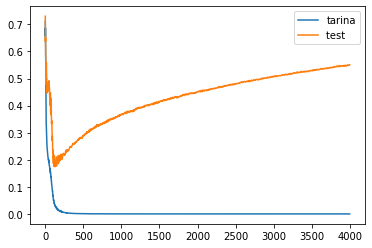

In [8]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


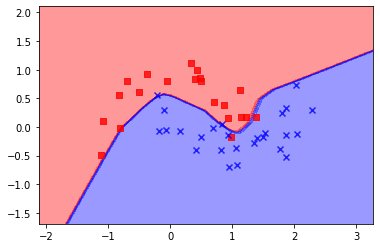

In [9]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

In [10]:
from tensorflow.keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam_1 = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dropout(0.8))
model.add(Dense(500,activation="sigmoid"))
model.add(Dropout(0.8))
model.add(Dense(200,activation="sigmoid"))
model.add(Dropout(0.8))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=4000, callbacks=[history_Adam_1])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1000)              3000      
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 500)               500500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 200)               100200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

Epoch 50/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.3830 - accuracy: 0.8679 - val_loss: 0.4633 - val_accuracy: 0.7660
Epoch 51/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.3361 - accuracy: 0.8868 - val_loss: 0.4657 - val_accuracy: 0.7447
Epoch 52/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.4761 - accuracy: 0.8302 - val_loss: 0.4685 - val_accuracy: 0.7447
Epoch 53/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.4200 - accuracy: 0.7547 - val_loss: 0.4724 - val_accuracy: 0.7447
Epoch 54/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.4306 - accuracy: 0.7925 - val_loss: 0.4767 - val_accuracy: 0.7447
Epoch 55/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.4126 - accuracy: 0.8113 - val_loss: 0.4811 - val_accuracy: 0.7447
Epoch 56/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.4516 - accuracy: 0.8302 - val_loss: 0.4847 - val_accuracy: 0.7660
Epoch 

2/2 [==============================] - 0s 16ms/step - loss: 0.1945 - accuracy: 0.9057 - val_loss: 0.4977 - val_accuracy: 0.7872
Epoch 165/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.2157 - accuracy: 0.9434 - val_loss: 0.5001 - val_accuracy: 0.7872
Epoch 166/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.2850 - accuracy: 0.8868 - val_loss: 0.5039 - val_accuracy: 0.7872
Epoch 167/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.2141 - accuracy: 0.9057 - val_loss: 0.5067 - val_accuracy: 0.8085
Epoch 168/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.2629 - accuracy: 0.8868 - val_loss: 0.5109 - val_accuracy: 0.8298
Epoch 169/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.3791 - accuracy: 0.8302 - val_loss: 0.5107 - val_accuracy: 0.8298
Epoch 170/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.3083 - accuracy: 0.8868 - val_loss: 0.5106 - val_accuracy: 0.8298
Epoch 171/4000

2/2 [==============================] - 0s 17ms/step - loss: 0.2173 - accuracy: 0.9245 - val_loss: 0.4588 - val_accuracy: 0.8085
Epoch 279/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.2859 - accuracy: 0.8868 - val_loss: 0.4557 - val_accuracy: 0.8085
Epoch 280/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.3505 - accuracy: 0.8679 - val_loss: 0.4517 - val_accuracy: 0.8085
Epoch 281/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1770 - accuracy: 0.9245 - val_loss: 0.4475 - val_accuracy: 0.8085
Epoch 282/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.1861 - accuracy: 0.9434 - val_loss: 0.4458 - val_accuracy: 0.8085
Epoch 283/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.2322 - accuracy: 0.9057 - val_loss: 0.4454 - val_accuracy: 0.8085
Epoch 284/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.2629 - accuracy: 0.9245 - val_loss: 0.4447 - val_accuracy: 0.8085
Epoch 285/4000

2/2 [==============================] - 0s 15ms/step - loss: 0.1928 - accuracy: 0.8868 - val_loss: 0.4456 - val_accuracy: 0.8298
Epoch 336/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1775 - accuracy: 0.9434 - val_loss: 0.4450 - val_accuracy: 0.8298
Epoch 337/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.2038 - accuracy: 0.9245 - val_loss: 0.4430 - val_accuracy: 0.8298
Epoch 338/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.2128 - accuracy: 0.9245 - val_loss: 0.4412 - val_accuracy: 0.8298
Epoch 339/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.2335 - accuracy: 0.9057 - val_loss: 0.4388 - val_accuracy: 0.8298
Epoch 340/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.2109 - accuracy: 0.9434 - val_loss: 0.4379 - val_accuracy: 0.8298
Epoch 341/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1447 - accuracy: 0.9434 - val_loss: 0.4382 - val_accuracy: 0.8298
Epoch 342/4000

2/2 [==============================] - 0s 16ms/step - loss: 0.1850 - accuracy: 0.9245 - val_loss: 0.4146 - val_accuracy: 0.8511
Epoch 450/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1309 - accuracy: 0.9623 - val_loss: 0.4169 - val_accuracy: 0.8511
Epoch 451/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1457 - accuracy: 0.9811 - val_loss: 0.4173 - val_accuracy: 0.8511
Epoch 452/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1944 - accuracy: 0.9057 - val_loss: 0.4173 - val_accuracy: 0.8511
Epoch 453/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.1795 - accuracy: 0.9434 - val_loss: 0.4181 - val_accuracy: 0.8511
Epoch 454/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.2083 - accuracy: 0.9245 - val_loss: 0.4143 - val_accuracy: 0.8511
Epoch 455/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.1572 - accuracy: 0.9434 - val_loss: 0.4120 - val_accuracy: 0.8511
Epoch 456/4000

2/2 [==============================] - 0s 15ms/step - loss: 0.0613 - accuracy: 0.9811 - val_loss: 0.3463 - val_accuracy: 0.8723
Epoch 564/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.1142 - accuracy: 0.9434 - val_loss: 0.3417 - val_accuracy: 0.8723
Epoch 565/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.1320 - accuracy: 0.9623 - val_loss: 0.3382 - val_accuracy: 0.8723
Epoch 566/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.1276 - accuracy: 0.9623 - val_loss: 0.3314 - val_accuracy: 0.8723
Epoch 567/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.1433 - accuracy: 0.9434 - val_loss: 0.3262 - val_accuracy: 0.8723
Epoch 568/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.1022 - accuracy: 0.9434 - val_loss: 0.3216 - val_accuracy: 0.8723
Epoch 569/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.1622 - accuracy: 0.9434 - val_loss: 0.3214 - val_accuracy: 0.8723
Epoch 570/4000

2/2 [==============================] - 0s 15ms/step - loss: 0.0640 - accuracy: 0.9811 - val_loss: 0.2951 - val_accuracy: 0.8936
Epoch 678/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.1115 - accuracy: 0.9434 - val_loss: 0.2928 - val_accuracy: 0.8936
Epoch 679/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0726 - accuracy: 0.9623 - val_loss: 0.2902 - val_accuracy: 0.8936
Epoch 680/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0686 - accuracy: 0.9623 - val_loss: 0.2877 - val_accuracy: 0.8723
Epoch 681/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.1033 - accuracy: 0.9434 - val_loss: 0.2845 - val_accuracy: 0.8723
Epoch 682/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0553 - accuracy: 0.9811 - val_loss: 0.2804 - val_accuracy: 0.8723
Epoch 683/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0846 - accuracy: 0.9623 - val_loss: 0.2807 - val_accuracy: 0.8723
Epoch 684/4000

2/2 [==============================] - 0s 13ms/step - loss: 0.0784 - accuracy: 0.9623 - val_loss: 0.2334 - val_accuracy: 0.8936
Epoch 792/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0788 - accuracy: 0.9811 - val_loss: 0.2323 - val_accuracy: 0.8936
Epoch 793/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0818 - accuracy: 0.9811 - val_loss: 0.2303 - val_accuracy: 0.8936
Epoch 794/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0691 - accuracy: 0.9811 - val_loss: 0.2319 - val_accuracy: 0.8936
Epoch 795/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0725 - accuracy: 0.9623 - val_loss: 0.2358 - val_accuracy: 0.8936
Epoch 796/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0274 - accuracy: 1.0000 - val_loss: 0.2387 - val_accuracy: 0.8936
Epoch 797/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0258 - accuracy: 1.0000 - val_loss: 0.2407 - val_accuracy: 0.8936
Epoch 798/4000

2/2 [==============================] - 0s 15ms/step - loss: 0.0746 - accuracy: 0.9811 - val_loss: 0.3197 - val_accuracy: 0.8936
Epoch 906/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0210 - accuracy: 1.0000 - val_loss: 0.3300 - val_accuracy: 0.8936
Epoch 907/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0775 - accuracy: 0.9623 - val_loss: 0.3333 - val_accuracy: 0.8936
Epoch 908/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.1408 - accuracy: 0.9623 - val_loss: 0.3319 - val_accuracy: 0.8936
Epoch 909/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0541 - accuracy: 0.9623 - val_loss: 0.3287 - val_accuracy: 0.8936
Epoch 910/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0445 - accuracy: 0.9811 - val_loss: 0.3237 - val_accuracy: 0.8936
Epoch 911/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.1260 - accuracy: 0.9434 - val_loss: 0.3203 - val_accuracy: 0.8936
Epoch 912/4000

2/2 [==============================] - 0s 15ms/step - loss: 0.0291 - accuracy: 0.9811 - val_loss: 0.2677 - val_accuracy: 0.8936
Epoch 963/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0654 - accuracy: 0.9623 - val_loss: 0.2694 - val_accuracy: 0.8936
Epoch 964/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0188 - accuracy: 1.0000 - val_loss: 0.2712 - val_accuracy: 0.8936
Epoch 965/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0675 - accuracy: 0.9623 - val_loss: 0.2737 - val_accuracy: 0.9149
Epoch 966/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0711 - accuracy: 0.9623 - val_loss: 0.2766 - val_accuracy: 0.8936
Epoch 967/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0456 - accuracy: 0.9811 - val_loss: 0.2810 - val_accuracy: 0.8936
Epoch 968/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0350 - accuracy: 0.9811 - val_loss: 0.2871 - val_accuracy: 0.8936
Epoch 969/4000

Epoch 1076/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0198 - accuracy: 1.0000 - val_loss: 0.2415 - val_accuracy: 0.9149
Epoch 1077/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0225 - accuracy: 1.0000 - val_loss: 0.2409 - val_accuracy: 0.9149
Epoch 1078/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0265 - accuracy: 1.0000 - val_loss: 0.2402 - val_accuracy: 0.9149
Epoch 1079/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0267 - accuracy: 1.0000 - val_loss: 0.2396 - val_accuracy: 0.9149
Epoch 1080/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0267 - accuracy: 0.9811 - val_loss: 0.2396 - val_accuracy: 0.9149
Epoch 1081/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0146 - accuracy: 1.0000 - val_loss: 0.2400 - val_accuracy: 0.9149
Epoch 1082/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0203 - accuracy: 1.0000 - val_loss: 0.2411 - val_accuracy:

Epoch 1133/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.0804 - accuracy: 0.9811 - val_loss: 0.2844 - val_accuracy: 0.9149
Epoch 1134/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.2790 - val_accuracy: 0.8936
Epoch 1135/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0354 - accuracy: 0.9811 - val_loss: 0.2753 - val_accuracy: 0.8936
Epoch 1136/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0234 - accuracy: 0.9811 - val_loss: 0.2718 - val_accuracy: 0.8936
Epoch 1137/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0495 - accuracy: 0.9811 - val_loss: 0.2679 - val_accuracy: 0.8936
Epoch 1138/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0704 - accuracy: 0.9623 - val_loss: 0.2664 - val_accuracy: 0.8936
Epoch 1139/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0872 - accuracy: 0.9811 - val_loss: 0.2653 - val_accuracy:

2/2 [==============================] - 0s 17ms/step - loss: 0.0272 - accuracy: 0.9811 - val_loss: 0.2953 - val_accuracy: 0.9362
Epoch 1247/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0316 - accuracy: 0.9811 - val_loss: 0.2919 - val_accuracy: 0.9149
Epoch 1248/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0658 - accuracy: 0.9623 - val_loss: 0.2887 - val_accuracy: 0.9149
Epoch 1249/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0333 - accuracy: 0.9811 - val_loss: 0.2879 - val_accuracy: 0.9149
Epoch 1250/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0346 - accuracy: 1.0000 - val_loss: 0.2852 - val_accuracy: 0.8936
Epoch 1251/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0445 - accuracy: 0.9811 - val_loss: 0.2823 - val_accuracy: 0.8936
Epoch 1252/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0243 - accuracy: 0.9811 - val_loss: 0.2800 - val_accuracy: 0.8936
Epoch 12

Epoch 1303/4000
2/2 [==============================] - 0s 23ms/step - loss: 0.0566 - accuracy: 0.9623 - val_loss: 0.3153 - val_accuracy: 0.8936
Epoch 1304/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0290 - accuracy: 0.9811 - val_loss: 0.3189 - val_accuracy: 0.8936
Epoch 1305/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0668 - accuracy: 0.9434 - val_loss: 0.3236 - val_accuracy: 0.8936
Epoch 1306/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 0.3277 - val_accuracy: 0.8936
Epoch 1307/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0173 - accuracy: 1.0000 - val_loss: 0.3338 - val_accuracy: 0.8936
Epoch 1308/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.0934 - accuracy: 0.9623 - val_loss: 0.3403 - val_accuracy: 0.9149
Epoch 1309/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0354 - accuracy: 0.9811 - val_loss: 0.3474 - val_accuracy:

2/2 [==============================] - 0s 15ms/step - loss: 0.0617 - accuracy: 0.9811 - val_loss: 0.3546 - val_accuracy: 0.8723
Epoch 1417/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.3529 - val_accuracy: 0.8723
Epoch 1418/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0271 - accuracy: 0.9811 - val_loss: 0.3520 - val_accuracy: 0.8723
Epoch 1419/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.9811 - val_loss: 0.3509 - val_accuracy: 0.8936
Epoch 1420/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0208 - accuracy: 0.9811 - val_loss: 0.3502 - val_accuracy: 0.8936
Epoch 1421/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0304 - accuracy: 0.9811 - val_loss: 0.3501 - val_accuracy: 0.8936
Epoch 1422/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.3509 - val_accuracy: 0.8936
Epoch 14

2/2 [==============================] - 0s 15ms/step - loss: 0.1069 - accuracy: 0.9811 - val_loss: 0.3216 - val_accuracy: 0.8936
Epoch 1474/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.3311 - val_accuracy: 0.8936
Epoch 1475/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.3393 - val_accuracy: 0.8936
Epoch 1476/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0250 - accuracy: 0.9811 - val_loss: 0.3471 - val_accuracy: 0.8936
Epoch 1477/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0537 - accuracy: 0.9811 - val_loss: 0.3545 - val_accuracy: 0.8936
Epoch 1478/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0356 - accuracy: 0.9811 - val_loss: 0.3609 - val_accuracy: 0.8936
Epoch 1479/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0720 - accuracy: 0.9623 - val_loss: 0.3665 - val_accuracy: 0.9149
Epoch 14

2/2 [==============================] - 0s 15ms/step - loss: 0.0224 - accuracy: 1.0000 - val_loss: 0.3881 - val_accuracy: 0.8936
Epoch 1531/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0227 - accuracy: 0.9811 - val_loss: 0.3774 - val_accuracy: 0.8723
Epoch 1532/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0359 - accuracy: 0.9811 - val_loss: 0.3696 - val_accuracy: 0.8936
Epoch 1533/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0318 - accuracy: 0.9811 - val_loss: 0.3623 - val_accuracy: 0.8936
Epoch 1534/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0276 - accuracy: 0.9811 - val_loss: 0.3562 - val_accuracy: 0.8936
Epoch 1535/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0527 - accuracy: 0.9623 - val_loss: 0.3619 - val_accuracy: 0.8936
Epoch 1536/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0242 - accuracy: 0.9811 - val_loss: 0.3662 - val_accuracy: 0.8936
Epoch 15

2/2 [==============================] - 0s 15ms/step - loss: 0.0338 - accuracy: 0.9811 - val_loss: 0.3643 - val_accuracy: 0.9149
Epoch 1588/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.3650 - val_accuracy: 0.9149
Epoch 1589/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0514 - accuracy: 0.9811 - val_loss: 0.3662 - val_accuracy: 0.9149
Epoch 1590/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.3675 - val_accuracy: 0.9149
Epoch 1591/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.3678 - val_accuracy: 0.9149
Epoch 1592/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.3678 - val_accuracy: 0.9149
Epoch 1593/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0495 - accuracy: 0.9811 - val_loss: 0.3680 - val_accuracy: 0.9149
Epoch 15

2/2 [==============================] - 0s 15ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.3550 - val_accuracy: 0.9149
Epoch 1645/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0454 - accuracy: 0.9811 - val_loss: 0.3553 - val_accuracy: 0.9149
Epoch 1646/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.3556 - val_accuracy: 0.9149
Epoch 1647/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0160 - accuracy: 0.9811 - val_loss: 0.3563 - val_accuracy: 0.9149
Epoch 1648/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0293 - accuracy: 0.9811 - val_loss: 0.3540 - val_accuracy: 0.9149
Epoch 1649/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.3525 - val_accuracy: 0.9149
Epoch 1650/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0220 - accuracy: 1.0000 - val_loss: 0.3497 - val_accuracy: 0.9149
Epoch 16

2/2 [==============================] - 0s 18ms/step - loss: 0.0701 - accuracy: 0.9811 - val_loss: 0.4775 - val_accuracy: 0.8936
Epoch 1702/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0920 - accuracy: 0.9623 - val_loss: 0.4812 - val_accuracy: 0.8936
Epoch 1703/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0700 - accuracy: 0.9623 - val_loss: 0.4767 - val_accuracy: 0.8936
Epoch 1704/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.0201 - accuracy: 0.9811 - val_loss: 0.4736 - val_accuracy: 0.8936
Epoch 1705/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.4707 - val_accuracy: 0.8936
Epoch 1706/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0250 - accuracy: 1.0000 - val_loss: 0.4673 - val_accuracy: 0.8936
Epoch 1707/4000
2/2 [==============================] - 0s 22ms/step - loss: 0.0322 - accuracy: 0.9811 - val_loss: 0.4584 - val_accuracy: 0.8936
Epoch 17

2/2 [==============================] - 0s 14ms/step - loss: 0.0661 - accuracy: 0.9623 - val_loss: 0.4259 - val_accuracy: 0.8936
Epoch 1759/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.4219 - val_accuracy: 0.8936
Epoch 1760/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.4189 - val_accuracy: 0.8936
Epoch 1761/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0220 - accuracy: 1.0000 - val_loss: 0.4162 - val_accuracy: 0.8936
Epoch 1762/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0224 - accuracy: 0.9811 - val_loss: 0.4132 - val_accuracy: 0.9149
Epoch 1763/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0353 - accuracy: 0.9811 - val_loss: 0.4088 - val_accuracy: 0.9149
Epoch 1764/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0201 - accuracy: 0.9811 - val_loss: 0.4054 - val_accuracy: 0.9149
Epoch 17

2/2 [==============================] - 0s 19ms/step - loss: 0.0449 - accuracy: 0.9811 - val_loss: 0.3905 - val_accuracy: 0.9149
Epoch 1816/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0259 - accuracy: 0.9811 - val_loss: 0.3886 - val_accuracy: 0.9149
Epoch 1817/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0242 - accuracy: 0.9811 - val_loss: 0.3877 - val_accuracy: 0.9149
Epoch 1818/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0266 - accuracy: 1.0000 - val_loss: 0.3885 - val_accuracy: 0.9149
Epoch 1819/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0192 - accuracy: 1.0000 - val_loss: 0.3906 - val_accuracy: 0.9149
Epoch 1820/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.3926 - val_accuracy: 0.9149
Epoch 1821/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0218 - accuracy: 1.0000 - val_loss: 0.3941 - val_accuracy: 0.9149
Epoch 18

Epoch 1872/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0160 - accuracy: 0.9811 - val_loss: 0.4077 - val_accuracy: 0.9149
Epoch 1873/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.4086 - val_accuracy: 0.9149
Epoch 1874/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1705 - accuracy: 0.9434 - val_loss: 0.4103 - val_accuracy: 0.9149
Epoch 1875/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.4105 - val_accuracy: 0.9149
Epoch 1876/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0696 - accuracy: 0.9811 - val_loss: 0.4028 - val_accuracy: 0.9149
Epoch 1877/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.3954 - val_accuracy: 0.9149
Epoch 1878/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0627 - accuracy: 0.9811 - val_loss: 0.3861 - val_accuracy:

Epoch 1929/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0531 - accuracy: 0.9811 - val_loss: 0.4653 - val_accuracy: 0.8936
Epoch 1930/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.4592 - val_accuracy: 0.8936
Epoch 1931/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0143 - accuracy: 0.9811 - val_loss: 0.4547 - val_accuracy: 0.9149
Epoch 1932/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 0.4521 - val_accuracy: 0.9149
Epoch 1933/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0408 - accuracy: 0.9623 - val_loss: 0.4464 - val_accuracy: 0.9149
Epoch 1934/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0185 - accuracy: 0.9811 - val_loss: 0.4425 - val_accuracy: 0.9149
Epoch 1935/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0259 - accuracy: 1.0000 - val_loss: 0.4372 - val_accuracy:

Epoch 2042/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0209 - accuracy: 0.9811 - val_loss: 0.4745 - val_accuracy: 0.8936
Epoch 2043/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.4698 - val_accuracy: 0.8936
Epoch 2044/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.4672 - val_accuracy: 0.8936
Epoch 2045/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0281 - accuracy: 0.9811 - val_loss: 0.4670 - val_accuracy: 0.9149
Epoch 2046/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.4671 - val_accuracy: 0.9149
Epoch 2047/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.4663 - val_accuracy: 0.9149
Epoch 2048/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0343 - accuracy: 0.9811 - val_loss: 0.4633 - val_accuracy:

Epoch 2099/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0432 - accuracy: 0.9811 - val_loss: 0.3998 - val_accuracy: 0.9149
Epoch 2100/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.4142 - val_accuracy: 0.9149
Epoch 2101/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0564 - accuracy: 0.9623 - val_loss: 0.4263 - val_accuracy: 0.9149
Epoch 2102/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.4365 - val_accuracy: 0.9149
Epoch 2103/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.4441 - val_accuracy: 0.9149
Epoch 2104/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0241 - accuracy: 0.9811 - val_loss: 0.4464 - val_accuracy: 0.9149
Epoch 2105/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0172 - accuracy: 1.0000 - val_loss: 0.4456 - val_accuracy:

Epoch 2156/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 0.4657 - val_accuracy: 0.8936
Epoch 2157/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.4728 - val_accuracy: 0.8936
Epoch 2158/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.4791 - val_accuracy: 0.8936
Epoch 2159/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.4837 - val_accuracy: 0.8936
Epoch 2160/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0282 - accuracy: 0.9811 - val_loss: 0.4783 - val_accuracy: 0.8936
Epoch 2161/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0733 - accuracy: 0.9623 - val_loss: 0.4716 - val_accuracy: 0.8936
Epoch 2162/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0716 - accuracy: 0.9811 - val_loss: 0.4696 - val_accuracy:

Epoch 2213/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.4408 - val_accuracy: 0.9149
Epoch 2214/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.4408 - val_accuracy: 0.9149
Epoch 2215/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0356 - accuracy: 0.9623 - val_loss: 0.4406 - val_accuracy: 0.9149
Epoch 2216/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0733 - accuracy: 0.9811 - val_loss: 0.4372 - val_accuracy: 0.9149
Epoch 2217/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.4312 - val_accuracy: 0.9149
Epoch 2218/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0156 - accuracy: 1.0000 - val_loss: 0.4265 - val_accuracy: 0.9149
Epoch 2219/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0481 - accuracy: 0.9811 - val_loss: 0.4209 - val_accuracy:

Epoch 2270/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.4655 - val_accuracy: 0.9149
Epoch 2271/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.4646 - val_accuracy: 0.9149
Epoch 2272/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.4644 - val_accuracy: 0.9149
Epoch 2273/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0201 - accuracy: 0.9811 - val_loss: 0.4661 - val_accuracy: 0.8936
Epoch 2274/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.4685 - val_accuracy: 0.8936
Epoch 2275/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.4700 - val_accuracy: 0.8936
Epoch 2276/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0291 - accuracy: 0.9811 - val_loss: 0.4732 - val_accuracy:

Epoch 2327/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.4757 - val_accuracy: 0.9149
Epoch 2328/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.4766 - val_accuracy: 0.9149
Epoch 2329/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.4795 - val_accuracy: 0.9149
Epoch 2330/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.4813 - val_accuracy: 0.9149
Epoch 2331/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0520 - accuracy: 0.9811 - val_loss: 0.4831 - val_accuracy: 0.9149
Epoch 2332/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.4862 - val_accuracy: 0.9149
Epoch 2333/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0500 - accuracy: 0.9623 - val_loss: 0.4857 - val_accuracy:

Epoch 2384/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.4761 - val_accuracy: 0.9149
Epoch 2385/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.4749 - val_accuracy: 0.9149
Epoch 2386/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0183 - accuracy: 0.9811 - val_loss: 0.4751 - val_accuracy: 0.9149
Epoch 2387/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.4773 - val_accuracy: 0.9149
Epoch 2388/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0167 - accuracy: 0.9811 - val_loss: 0.4805 - val_accuracy: 0.9149
Epoch 2389/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.4840 - val_accuracy: 0.9149
Epoch 2390/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0275 - accuracy: 0.9811 - val_loss: 0.4889 - val_accuracy:

Epoch 2441/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.4635 - val_accuracy: 0.8936
Epoch 2442/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0421 - accuracy: 0.9811 - val_loss: 0.4671 - val_accuracy: 0.8936
Epoch 2443/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.4703 - val_accuracy: 0.8936
Epoch 2444/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0247 - accuracy: 0.9811 - val_loss: 0.4708 - val_accuracy: 0.8936
Epoch 2445/4000
2/2 [==============================] - 0s 15ms/step - loss: 7.6092e-04 - accuracy: 1.0000 - val_loss: 0.4712 - val_accuracy: 0.8936
Epoch 2446/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0134 - accuracy: 0.9811 - val_loss: 0.4689 - val_accuracy: 0.8936
Epoch 2447/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4672 - val_accur

Epoch 2498/4000
2/2 [==============================] - 0s 24ms/step - loss: 0.0203 - accuracy: 0.9811 - val_loss: 0.5644 - val_accuracy: 0.9149
Epoch 2499/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.5635 - val_accuracy: 0.9149
Epoch 2500/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.5624 - val_accuracy: 0.8936
Epoch 2501/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0205 - accuracy: 0.9811 - val_loss: 0.5628 - val_accuracy: 0.8936
Epoch 2502/4000
2/2 [==============================] - 0s 22ms/step - loss: 0.0154 - accuracy: 1.0000 - val_loss: 0.5625 - val_accuracy: 0.8936
Epoch 2503/4000
2/2 [==============================] - 0s 25ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.5620 - val_accuracy: 0.8936
Epoch 2504/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.5615 - val_accuracy:

Epoch 2555/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0161 - accuracy: 1.0000 - val_loss: 0.4626 - val_accuracy: 0.9149
Epoch 2556/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0245 - accuracy: 0.9811 - val_loss: 0.4641 - val_accuracy: 0.9149
Epoch 2557/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.4652 - val_accuracy: 0.9149
Epoch 2558/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.4662 - val_accuracy: 0.9149
Epoch 2559/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.4673 - val_accuracy: 0.9149
Epoch 2560/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.4686 - val_accuracy: 0.9149
Epoch 2561/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.4695 - val_accuracy:

Epoch 2612/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0563 - accuracy: 0.9811 - val_loss: 0.5254 - val_accuracy: 0.9149
Epoch 2613/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.5112 - val_accuracy: 0.9149
Epoch 2614/4000
2/2 [==============================] - 0s 15ms/step - loss: 2.5316e-04 - accuracy: 1.0000 - val_loss: 0.5009 - val_accuracy: 0.9149
Epoch 2615/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.1216 - accuracy: 0.9811 - val_loss: 0.4931 - val_accuracy: 0.8936
Epoch 2616/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.4873 - val_accuracy: 0.8936
Epoch 2617/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.4836 - val_accuracy: 0.8936
Epoch 2618/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.4813 - val_accur

Epoch 2669/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.4854 - val_accuracy: 0.9149
Epoch 2670/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.4897 - val_accuracy: 0.8936
Epoch 2671/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0704 - accuracy: 0.9811 - val_loss: 0.4891 - val_accuracy: 0.8936
Epoch 2672/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.4888 - val_accuracy: 0.8936
Epoch 2673/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.4877 - val_accuracy: 0.9149
Epoch 2674/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0335 - accuracy: 0.9811 - val_loss: 0.4886 - val_accuracy: 0.9149
Epoch 2675/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.4929 - val_accuracy:

Epoch 2726/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0311 - accuracy: 0.9623 - val_loss: 0.5145 - val_accuracy: 0.8936
Epoch 2727/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.5092 - val_accuracy: 0.8936
Epoch 2728/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0362 - accuracy: 0.9811 - val_loss: 0.5032 - val_accuracy: 0.8936
Epoch 2729/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.4977 - val_accuracy: 0.8936
Epoch 2730/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.4934 - val_accuracy: 0.8936
Epoch 2731/4000
2/2 [==============================] - 0s 15ms/step - loss: 8.8968e-04 - accuracy: 1.0000 - val_loss: 0.4899 - val_accuracy: 0.8936
Epoch 2732/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.4869 - val_accur

Epoch 2783/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0136 - accuracy: 0.9811 - val_loss: 0.5088 - val_accuracy: 0.9149
Epoch 2784/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.5061 - val_accuracy: 0.9149
Epoch 2785/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.5045 - val_accuracy: 0.9149
Epoch 2786/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.5047 - val_accuracy: 0.9149
Epoch 2787/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0374 - accuracy: 0.9623 - val_loss: 0.5052 - val_accuracy: 0.9149
Epoch 2788/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.5058 - val_accuracy: 0.9149
Epoch 2789/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.5065 - val_accuracy:

Epoch 2840/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.6291 - val_accuracy: 0.9149
Epoch 2841/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0427 - accuracy: 0.9811 - val_loss: 0.6271 - val_accuracy: 0.9149
Epoch 2842/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.6226 - val_accuracy: 0.9149
Epoch 2843/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.6197 - val_accuracy: 0.9149
Epoch 2844/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.6176 - val_accuracy: 0.9149
Epoch 2845/4000
2/2 [==============================] - 0s 23ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.6158 - val_accuracy: 0.9149
Epoch 2846/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.6145 - val_accuracy:

Epoch 2897/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0311 - accuracy: 0.9811 - val_loss: 0.5470 - val_accuracy: 0.9149
Epoch 2898/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.5584 - val_accuracy: 0.9149
Epoch 2899/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.5677 - val_accuracy: 0.9149
Epoch 2900/4000
2/2 [==============================] - 0s 15ms/step - loss: 8.7243e-04 - accuracy: 1.0000 - val_loss: 0.5755 - val_accuracy: 0.9149
Epoch 2901/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.5817 - val_accuracy: 0.9149
Epoch 2902/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.5839 - val_accuracy: 0.9149
Epoch 2903/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.5834 - val_accur

Epoch 2954/4000
2/2 [==============================] - 0s 22ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.5216 - val_accuracy: 0.9149
Epoch 2955/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.5230 - val_accuracy: 0.9149
Epoch 2956/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.5237 - val_accuracy: 0.9149
Epoch 2957/4000
2/2 [==============================] - 0s 16ms/step - loss: 4.9733e-04 - accuracy: 1.0000 - val_loss: 0.5238 - val_accuracy: 0.8936
Epoch 2958/4000
2/2 [==============================] - 0s 15ms/step - loss: 3.9229e-04 - accuracy: 1.0000 - val_loss: 0.5239 - val_accuracy: 0.8936
Epoch 2959/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.5248 - val_accuracy: 0.8936
Epoch 2960/4000
2/2 [==============================] - 0s 15ms/step - loss: 8.2185e-04 - accuracy: 1.0000 - val_loss: 0.5256 - v

Epoch 3067/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.5141 - val_accuracy: 0.9149
Epoch 3068/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0882 - accuracy: 0.9811 - val_loss: 0.5341 - val_accuracy: 0.9149
Epoch 3069/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.5517 - val_accuracy: 0.9149
Epoch 3070/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.5665 - val_accuracy: 0.9149
Epoch 3071/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.5783 - val_accuracy: 0.9149
Epoch 3072/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.5886 - val_accuracy: 0.9149
Epoch 3073/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0144 - accuracy: 0.9811 - val_loss: 0.5981 - val_accuracy:

Epoch 3124/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.7493 - val_accuracy: 0.8936
Epoch 3125/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.7521 - val_accuracy: 0.8936
Epoch 3126/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0371 - accuracy: 0.9811 - val_loss: 0.7520 - val_accuracy: 0.8936
Epoch 3127/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.7519 - val_accuracy: 0.8936
Epoch 3128/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.7513 - val_accuracy: 0.8936
Epoch 3129/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0267 - accuracy: 0.9811 - val_loss: 0.7433 - val_accuracy: 0.8936
Epoch 3130/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.7255 - val_accuracy:

Epoch 3181/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.5345 - val_accuracy: 0.9149
Epoch 3182/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.5337 - val_accuracy: 0.9149
Epoch 3183/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.5348 - val_accuracy: 0.9149
Epoch 3184/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.5359 - val_accuracy: 0.9149
Epoch 3185/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.5369 - val_accuracy: 0.9149
Epoch 3186/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.5376 - val_accuracy: 0.9149
Epoch 3187/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0158 - accuracy: 1.0000 - val_loss: 0.5393 - val_accuracy:

Epoch 3238/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 0.4814 - val_accuracy: 0.9149
Epoch 3239/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.4809 - val_accuracy: 0.9149
Epoch 3240/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.4809 - val_accuracy: 0.9149
Epoch 3241/4000
2/2 [==============================] - 0s 14ms/step - loss: 9.3108e-04 - accuracy: 1.0000 - val_loss: 0.4811 - val_accuracy: 0.9149
Epoch 3242/4000
2/2 [==============================] - 0s 16ms/step - loss: 3.7576e-04 - accuracy: 1.0000 - val_loss: 0.4813 - val_accuracy: 0.9149
Epoch 3243/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.4815 - val_accuracy: 0.9149
Epoch 3244/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.4818 - val_a

Epoch 3295/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0967 - accuracy: 0.9811 - val_loss: 0.4795 - val_accuracy: 0.9362
Epoch 3296/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.4730 - val_accuracy: 0.9362
Epoch 3297/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 0.4681 - val_accuracy: 0.9362
Epoch 3298/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0427 - accuracy: 0.9811 - val_loss: 0.4668 - val_accuracy: 0.9362
Epoch 3299/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.4674 - val_accuracy: 0.9362
Epoch 3300/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0217 - accuracy: 0.9811 - val_loss: 0.4703 - val_accuracy: 0.9362
Epoch 3301/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0214 - accuracy: 0.9811 - val_loss: 0.4767 - val_accuracy:

Epoch 3408/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.5566 - val_accuracy: 0.9149
Epoch 3409/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0326 - accuracy: 0.9811 - val_loss: 0.5449 - val_accuracy: 0.9149
Epoch 3410/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0569 - accuracy: 0.9811 - val_loss: 0.5343 - val_accuracy: 0.9149
Epoch 3411/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0204 - accuracy: 1.0000 - val_loss: 0.5260 - val_accuracy: 0.9149
Epoch 3412/4000
2/2 [==============================] - 0s 16ms/step - loss: 9.6286e-04 - accuracy: 1.0000 - val_loss: 0.5203 - val_accuracy: 0.9149
Epoch 3413/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.5163 - val_accuracy: 0.9362
Epoch 3414/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.5134 - val_accur

Epoch 3521/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.5631 - val_accuracy: 0.8936
Epoch 3522/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0178 - accuracy: 0.9811 - val_loss: 0.5621 - val_accuracy: 0.8936
Epoch 3523/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0352 - accuracy: 0.9811 - val_loss: 0.5563 - val_accuracy: 0.8936
Epoch 3524/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.5495 - val_accuracy: 0.9149
Epoch 3525/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.5450 - val_accuracy: 0.9149
Epoch 3526/4000
2/2 [==============================] - 0s 19ms/step - loss: 3.8047e-04 - accuracy: 1.0000 - val_loss: 0.5410 - val_accuracy: 0.9149
Epoch 3527/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.5391 - val_accur

Epoch 3578/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.5525 - val_accuracy: 0.9149
Epoch 3579/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.5536 - val_accuracy: 0.9149
Epoch 3580/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.5562 - val_accuracy: 0.9149
Epoch 3581/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.5583 - val_accuracy: 0.9149
Epoch 3582/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.5589 - val_accuracy: 0.9149
Epoch 3583/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0168 - accuracy: 1.0000 - val_loss: 0.5598 - val_accuracy: 0.9149
Epoch 3584/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.5599 - val_accuracy:

Epoch 3691/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.6826 - val_accuracy: 0.8936
Epoch 3692/4000
2/2 [==============================] - 0s 18ms/step - loss: 9.0447e-05 - accuracy: 1.0000 - val_loss: 0.6840 - val_accuracy: 0.8936
Epoch 3693/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.6852 - val_accuracy: 0.8936
Epoch 3694/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0869 - accuracy: 0.9811 - val_loss: 0.6933 - val_accuracy: 0.8936
Epoch 3695/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0536 - accuracy: 0.9811 - val_loss: 0.7011 - val_accuracy: 0.8936
Epoch 3696/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.7077 - val_accuracy: 0.8936
Epoch 3697/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.7129 - val_accur

Epoch 3804/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.6228 - val_accuracy: 0.9149
Epoch 3805/4000
2/2 [==============================] - 0s 14ms/step - loss: 9.2635e-04 - accuracy: 1.0000 - val_loss: 0.6209 - val_accuracy: 0.9149
Epoch 3806/4000
2/2 [==============================] - 0s 14ms/step - loss: 1.6330e-04 - accuracy: 1.0000 - val_loss: 0.6193 - val_accuracy: 0.9149
Epoch 3807/4000
2/2 [==============================] - 0s 16ms/step - loss: 8.7576e-04 - accuracy: 1.0000 - val_loss: 0.6182 - val_accuracy: 0.9149
Epoch 3808/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.6173 - val_accuracy: 0.9149
Epoch 3809/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.6167 - val_accuracy: 0.9149
Epoch 3810/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.6161 - v

Epoch 3917/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.5783 - val_accuracy: 0.9149
Epoch 3918/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.5792 - val_accuracy: 0.9149
Epoch 3919/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.5802 - val_accuracy: 0.9149
Epoch 3920/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.5811 - val_accuracy: 0.9149
Epoch 3921/4000
2/2 [==============================] - 0s 13ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.5821 - val_accuracy: 0.8936
Epoch 3922/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.5830 - val_accuracy: 0.8936
Epoch 3923/4000
2/2 [==============================] - 0s 16ms/step - loss: 3.8770e-04 - accuracy: 1.0000 - val_loss: 0.5836 - val_accur

Epoch 3974/4000
2/2 [==============================] - 0s 17ms/step - loss: 7.7102e-04 - accuracy: 1.0000 - val_loss: 0.5442 - val_accuracy: 0.9362
Epoch 3975/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.5438 - val_accuracy: 0.9362
Epoch 3976/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.5437 - val_accuracy: 0.9362
Epoch 3977/4000
2/2 [==============================] - 0s 19ms/step - loss: 5.9078e-04 - accuracy: 1.0000 - val_loss: 0.5438 - val_accuracy: 0.9362
Epoch 3978/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.5441 - val_accuracy: 0.9362
Epoch 3979/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.5452 - val_accuracy: 0.9362
Epoch 3980/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.5515 - val_a

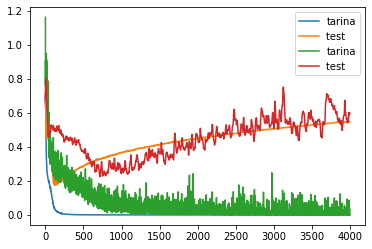

In [11]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")

plt.plot(history_Adam_1.history['loss'], label = "tarina")
plt.plot(history_Adam_1.history['val_loss'], label = "test ")

plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


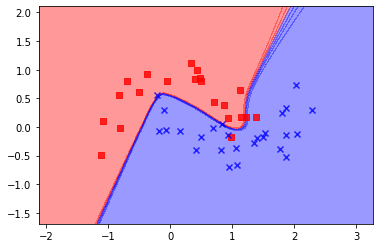

In [12]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

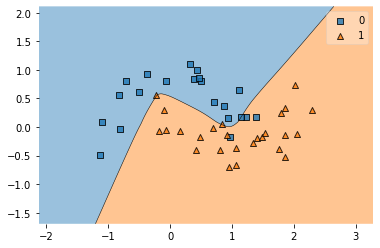

In [24]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

# Regularyzacja

# Zad.
Do do modelu 
* 
```python
model.add(Dense( ... , activity_regularizer=l1(0.00001)))
```
* 
```python
model.add(Dense( ... , activity_regularizer=l1(0.0001)))
```

* 
```python
model.add(Dense( ... , activity_regularizer=l2(0.00001)))
```
* 
```python
model.add(Dense( ... , activity_regularizer=l2(0.0001)))
```

w każdej warstwie.

Zwizualizuj wyniki dla obu modeli.

In [13]:
from tensorflow.keras.callbacks import History
from tensorflow.keras.regularizers import l1


history_Adam_2 = History()
model = Sequential()
model.add(Dense(1000,activation="sigmoid",input_shape=(X_train.shape[1],), activity_regularizer=l1(0.00001)))
model.add(Dense(500,activation="sigmoid", activity_regularizer=l1(0.00001)))
model.add(Dense(200,activation="sigmoid", activity_regularizer=l1(0.00001)))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam_2])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1000)              3000      
_________________________________________________________________
dense_13 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_14 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 0s 103ms/step - loss: 0.7759 - accuracy: 0.5094 - val_loss: 0.8096 - val_accuracy: 0.4468
Epoch 2/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.7910 - accuracy: 0.4151 - val

2/2 [==============================] - 0s 17ms/step - loss: 0.2766 - accuracy: 0.8491 - val_loss: 0.6199 - val_accuracy: 0.7660
Epoch 110/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.2782 - accuracy: 0.8491 - val_loss: 0.5174 - val_accuracy: 0.7872
Epoch 111/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.2577 - accuracy: 0.9057 - val_loss: 0.4552 - val_accuracy: 0.8085
Epoch 112/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.2920 - accuracy: 0.9057 - val_loss: 0.4804 - val_accuracy: 0.8085
Epoch 113/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.2675 - accuracy: 0.9057 - val_loss: 0.5339 - val_accuracy: 0.7660
Epoch 114/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.2752 - accuracy: 0.8868 - val_loss: 0.5949 - val_accuracy: 0.7660
Epoch 115/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2674 - accuracy: 0.8679 - val_loss: 0.5019 - val_accuracy: 0.7872
Epoch 116/1000

Epoch 223/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2580 - accuracy: 0.9057 - val_loss: 0.5574 - val_accuracy: 0.7660
Epoch 224/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.2592 - accuracy: 0.9057 - val_loss: 0.5446 - val_accuracy: 0.7660
Epoch 225/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2696 - accuracy: 0.9057 - val_loss: 0.5195 - val_accuracy: 0.7660
Epoch 226/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2578 - accuracy: 0.9057 - val_loss: 0.5524 - val_accuracy: 0.7660
Epoch 227/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2669 - accuracy: 0.8679 - val_loss: 0.5576 - val_accuracy: 0.7660
Epoch 228/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2575 - accuracy: 0.9057 - val_loss: 0.5051 - val_accuracy: 0.7872
Epoch 229/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2631 - accuracy: 0.8868 - val_loss: 0.4807 - val_accuracy: 0.8085

2/2 [==============================] - 0s 15ms/step - loss: 0.2687 - accuracy: 0.8491 - val_loss: 0.5578 - val_accuracy: 0.7660
Epoch 338/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2566 - accuracy: 0.8491 - val_loss: 0.5073 - val_accuracy: 0.7660
Epoch 339/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.2573 - accuracy: 0.9057 - val_loss: 0.4869 - val_accuracy: 0.8085
Epoch 340/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2667 - accuracy: 0.8868 - val_loss: 0.5035 - val_accuracy: 0.7660
Epoch 341/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2592 - accuracy: 0.9057 - val_loss: 0.5406 - val_accuracy: 0.7660
Epoch 342/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2580 - accuracy: 0.9057 - val_loss: 0.5640 - val_accuracy: 0.7660
Epoch 343/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2603 - accuracy: 0.8868 - val_loss: 0.5419 - val_accuracy: 0.7660
Epoch 344/1000

2/2 [==============================] - 0s 17ms/step - loss: 0.2553 - accuracy: 0.9057 - val_loss: 0.5349 - val_accuracy: 0.7660
Epoch 452/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2625 - accuracy: 0.9057 - val_loss: 0.5369 - val_accuracy: 0.7660
Epoch 453/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2545 - accuracy: 0.9057 - val_loss: 0.5618 - val_accuracy: 0.7660
Epoch 454/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2599 - accuracy: 0.8491 - val_loss: 0.5608 - val_accuracy: 0.7660
Epoch 455/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2575 - accuracy: 0.8491 - val_loss: 0.5287 - val_accuracy: 0.7660
Epoch 456/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2621 - accuracy: 0.9057 - val_loss: 0.4979 - val_accuracy: 0.7872
Epoch 457/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2620 - accuracy: 0.8868 - val_loss: 0.5147 - val_accuracy: 0.7660
Epoch 458/1000

2/2 [==============================] - 0s 16ms/step - loss: 0.2549 - accuracy: 0.9057 - val_loss: 0.5027 - val_accuracy: 0.7660
Epoch 566/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2575 - accuracy: 0.9057 - val_loss: 0.5064 - val_accuracy: 0.7660
Epoch 567/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2604 - accuracy: 0.9057 - val_loss: 0.5309 - val_accuracy: 0.7660
Epoch 568/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2536 - accuracy: 0.9057 - val_loss: 0.5400 - val_accuracy: 0.7660
Epoch 569/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2573 - accuracy: 0.9057 - val_loss: 0.5517 - val_accuracy: 0.7447
Epoch 570/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2548 - accuracy: 0.8868 - val_loss: 0.5335 - val_accuracy: 0.7660
Epoch 571/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.2540 - accuracy: 0.9057 - val_loss: 0.5259 - val_accuracy: 0.7660
Epoch 572/1000

2/2 [==============================] - 0s 14ms/step - loss: 0.2535 - accuracy: 0.9057 - val_loss: 0.5281 - val_accuracy: 0.7660
Epoch 680/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2520 - accuracy: 0.9057 - val_loss: 0.5428 - val_accuracy: 0.7660
Epoch 681/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2603 - accuracy: 0.8491 - val_loss: 0.5463 - val_accuracy: 0.7660
Epoch 682/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2618 - accuracy: 0.8491 - val_loss: 0.5125 - val_accuracy: 0.7660
Epoch 683/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2535 - accuracy: 0.9057 - val_loss: 0.5090 - val_accuracy: 0.7660
Epoch 684/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2530 - accuracy: 0.9057 - val_loss: 0.5066 - val_accuracy: 0.7660
Epoch 685/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2593 - accuracy: 0.9057 - val_loss: 0.5182 - val_accuracy: 0.7660
Epoch 686/1000

2/2 [==============================] - 0s 14ms/step - loss: 0.2515 - accuracy: 0.9057 - val_loss: 0.5189 - val_accuracy: 0.7660
Epoch 794/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.2521 - accuracy: 0.9057 - val_loss: 0.5123 - val_accuracy: 0.7660
Epoch 795/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.2544 - accuracy: 0.9057 - val_loss: 0.5207 - val_accuracy: 0.7660
Epoch 796/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2548 - accuracy: 0.9057 - val_loss: 0.5169 - val_accuracy: 0.7660
Epoch 797/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.2573 - accuracy: 0.9057 - val_loss: 0.5368 - val_accuracy: 0.7447
Epoch 798/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2532 - accuracy: 0.8679 - val_loss: 0.5329 - val_accuracy: 0.7660
Epoch 799/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2510 - accuracy: 0.9057 - val_loss: 0.5152 - val_accuracy: 0.7660
Epoch 800/1000

2/2 [==============================] - 0s 13ms/step - loss: 0.2539 - accuracy: 0.9057 - val_loss: 0.5266 - val_accuracy: 0.7660
Epoch 908/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2515 - accuracy: 0.9057 - val_loss: 0.5291 - val_accuracy: 0.7660
Epoch 909/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2551 - accuracy: 0.9057 - val_loss: 0.5214 - val_accuracy: 0.7660
Epoch 910/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2535 - accuracy: 0.9057 - val_loss: 0.5404 - val_accuracy: 0.7660
Epoch 911/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2526 - accuracy: 0.8679 - val_loss: 0.5528 - val_accuracy: 0.7660
Epoch 912/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.2517 - accuracy: 0.8491 - val_loss: 0.5470 - val_accuracy: 0.7447
Epoch 913/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.2524 - accuracy: 0.8679 - val_loss: 0.5339 - val_accuracy: 0.7447
Epoch 914/1000

In [ ]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")

# plt.plot(history_Adam_1.history['loss'], label = "tarina dropout")
# plt.plot(history_Adam_1.history['val_loss'], label = "test dropout")

plt.plot(history_Adam_2.history['loss'], label = "tarina l1")
plt.plot(history_Adam_2.history['val_loss'], label = "test l1")

plt.legend()
plt.show()

In [ ]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()